In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

from scipy.stats import zscore
from scipy.stats import kstest, norm, boxcox

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import silhouette_score,mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#FONCTIONS UTILES

def outliers(df, columns,seuil=3): #Suppression sur base du Z-score
  colonnes_specifiques = df[columns]
  z_scores_specifiques = np.abs(zscore(colonnes_specifiques))
  masque_outliers = (z_scores_specifiques < seuil).all(axis=1)
  new_df = df[masque_outliers]
  n0=df.shape[0]
  n1=new_df.shape[0]
  print("Nombre de ligne initialement", n0)
  print("Nombre de lignes supprimées", n0 - n1)
  if(n0>0):
    print("Pourcentage supprimé", (n0 - n1)/n0 *100)
  return new_df

def drop(df): #Suppression de la ligne si il manque une donnée
  lg_0=len(df)
  new_df = df.dropna().copy()
  lg_1=len(new_df)
  print("Nombre de lignes supprimées : ", lg_0-lg_1)
  print("Lignes restantes : ", lg_1)
  if(lg_0>0):
    print("Pourcentage supprimé : ", (lg_0-lg_1)/lg_0*100)
  return new_df


## Fusion de tout les datasets entre eux (à faire qu'une seule fois)

In [ ]:
#Importation et fusion des csv de meteo : A FAIRE QU'UNE FOIS
paths_weather = [
    f'/content/drive/MyDrive/Projet 442-1 DATA/weather/synop.{annee}{mois:02d}.csv'
    for annee in range(2007, 2011)  # De 2007 à 2010 inclus
    for mois in range(1, 13)  # De janvier (1) à décembre (12)
]

dataframes_weather = [pd.read_csv(path, sep=';') for path in paths_weather]


df_weather_combined = pd.concat(dataframes_weather, ignore_index=True)

df_weather_combined.to_csv('/content/drive/MyDrive/Projet 442-1 DATA/weather/synop.total.csv', index=False)

In [ ]:
#Importation et fusion des csv de conso : A FAIRE QU'UNE FOIS
paths_consumption = [
    '/content/drive/MyDrive/Projet 442-1 DATA/household_power_consumption/household_power_consumption_2007.csv',
    '/content/drive/MyDrive/Projet 442-1 DATA/household_power_consumption/household_power_consumption_2008.csv',
    '/content/drive/MyDrive/Projet 442-1 DATA/household_power_consumption/household_power_consumption_2009.csv',
    '/content/drive/MyDrive/Projet 442-1 DATA/household_power_consumption/household_power_consumption_2010.csv'
]
columns_conso_names=['date','time','global_active_power','global_reactive_power','voltage','global_intensity','sub_metering_1','sub_metering_2','sub_metering_3']

dataframes_conso = [pd.read_csv(path,sep=';',names=columns_conso_names, low_memory=False) for path in paths_consumption]

combined_df = pd.concat(dataframes_conso, ignore_index=True)

combined_df.to_csv('/content/drive/MyDrive/Projet 442-1 DATA/household_power_consumption/household_power_consumption_all.csv', index=False)

## Import


In [ ]:
#Import depuis Google Drive le dataset total consommation energétique
path_conso='/content/drive/MyDrive/Projet 442-1 DATA/household_power_consumption/household_power_consumption_all.csv'
df_conso=pd.read_csv(path_conso)


<ipython-input-5-ee2993b00e9e>:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_conso=pd.read_csv(path_conso)


In [ ]:
#Import depuis Google Drive le dataset total weather
path_weather='/content/drive/MyDrive/Projet 442-1 DATA/weather/synop.total.csv'
df_weather_1=pd.read_csv(path_weather)

## Prétraitement Weather

In [ ]:
#Garder que la station de Orly (la plus proche)
df_weather_orly = df_weather_1[df_weather_1['numer_sta'] == 7149]

#Convertir ce qui est possible en float, le reste devient NaN
for column in df_weather_orly.columns:
    df_weather_orly[column] = pd.to_numeric(df_weather_orly[column], errors='coerce')

<ipython-input-7-bc65776ebccc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather_orly[column] = pd.to_numeric(df_weather_orly[column], errors='coerce')


In [ ]:
#Supprimer les colonnes vides
empty_columns=['numer_sta','niv_bar','geop','tend24','tn24','tx24','sw','tw','Unnamed: 59']
df_weather_orly_empty = df_weather_orly.drop(empty_columns, axis=1).copy()

In [ ]:
df_weather_orly_empty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11656 entries, 9 to 679156
Data columns (total 51 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       11656 non-null  int64  
 1   pmer       11649 non-null  float64
 2   tend       11629 non-null  float64
 3   cod_tend   11629 non-null  float64
 4   dd         11653 non-null  float64
 5   ff         11653 non-null  float64
 6   t          11649 non-null  float64
 7   td         11649 non-null  float64
 8   u          11649 non-null  float64
 9   vv         11648 non-null  float64
 10  ww         11638 non-null  float64
 11  w1         11261 non-null  float64
 12  w2         11261 non-null  float64
 13  n          11410 non-null  float64
 14  nbas       10099 non-null  float64
 15  hbas       10340 non-null  float64
 16  cl         10167 non-null  float64
 17  cm         10167 non-null  float64
 18  ch         10167 non-null  float64
 19  pres       11654 non-null  float64
 20  tn12      

In [ ]:
#Etudes colonnes avec peu de données
colonnes_interet = ['nnuage4', 'ctype4', 'hnuage4','phenspe4','tn12','tx12','tminsol','etat_sol','hnuage2','ctype2','nnuage2','hnuage3','ctype3','nnuage3']
df_weather_orly_empty[colonnes_interet].describe()

,nnuage4,ctype4,hnuage4,phenspe4,tn12,tx12,tminsol,etat_sol,hnuage2,ctype2,nnuage2,hnuage3,ctype3,nnuage3
count,26.000000,26.000000,26.000000,233.000000,2915.000000,2915.000000,1456.000000,1827.000000,5821.000000,5821.000000,5821.000000,1267.000000,1267.000000,1267.000000
mean,6.269231,3.384615,3379.615385,3100.017167,281.190309,287.816072,278.458379,3.835249,2673.617935,4.461605,5.444082,3689.881610,3.362273,6.315706
std,0.961569,2.299164,2392.231562,0.159894,6.228089,7.759458,6.407713,5.692533,2688.856769,2.690529,1.662454,2798.758482,2.714818,1.109245
min,5.000000,0.000000,720.000000,3100.000000,259.850000,265.650000,257.150000,0.000000,30.000000,0.000000,1.000000,90.000000,0.000000,1.000000
25%,5.250000,3.000000,1575.000000,3100.000000,276.650000,282.150000,274.150000,0.000000,750.000000,3.000000,4.000000,1350.000000,0.000000,6.000000
50%,6.000000,3.000000,3000.000000,3100.000000,281.550000,287.950000,279.150000,1.000000,1500.000000,6.000000,6.000000,3000.000000,3.000000,7.000000
75%,7.000000,6.000000,3000.000000,3100.000000,286.350000,293.850000,283.150000,11.000000,3000.000000,6.000000,7.000000,7500.000000,6.000000,7.000000
max,8.000000,6.000000,7800.000000,3102.000000,296.350000,308.950000,292.150000,18.000000,7800.000000,9.000000,8.000000,7800.000000,9.000000,8.000000


In [ ]:
#On supprime toutes les colonnes avec peu de données
df_weather_orly_empty_naive = df_weather_orly_empty.drop(colonnes_interet, axis=1).copy()

#df_weather_orly_empty_naive.info()

In [ ]:
#Completion des données manquantes pour les features restantes

#Mettre Zéro sur les trous
columns_zero = ['ssfrai','ht_neige', 'hbas', 'cl', 'cm','ch','rafper','raf10','rr6','rr12','rr24']
df_weather_orly_empty_naive[columns_zero] = df_weather_orly_empty_naive[columns_zero].fillna(0)

#Mettre les valeurs précédentes sur les trous
colonnes_ffil = []
df_weather_orly_empty_naive[colonnes_ffil] = df_weather_orly_empty_naive[colonnes_ffil].fillna(method='ffill')

#Mettre la valeur la plus répandue de la colonne dans le trou
colonnes_a_mode = ['pres', 'nnuage1','ctype1','hnuage1','nbas']
for col in colonnes_a_mode:
    mode_value = df_weather_orly_empty_naive[col].mode()[0]
    df_weather_orly_empty_naive[col] = df_weather_orly_empty_naive[col].fillna(mode_value)

#df_weather_orly_empty_naive.info()

In [ ]:
#Suppression des lignes avec donnée manquante
df_weather_naive_dropna=drop(df_weather_orly_empty_naive)

Nombre de lignes supprimées :  580
Lignes restantes :  11076
Pourcentage supprimé :  4.975978037062457


Nombre de ligne initialement 11076
Nombre de lignes supprimées 558
Pourcentage supprimé 5.037919826652221


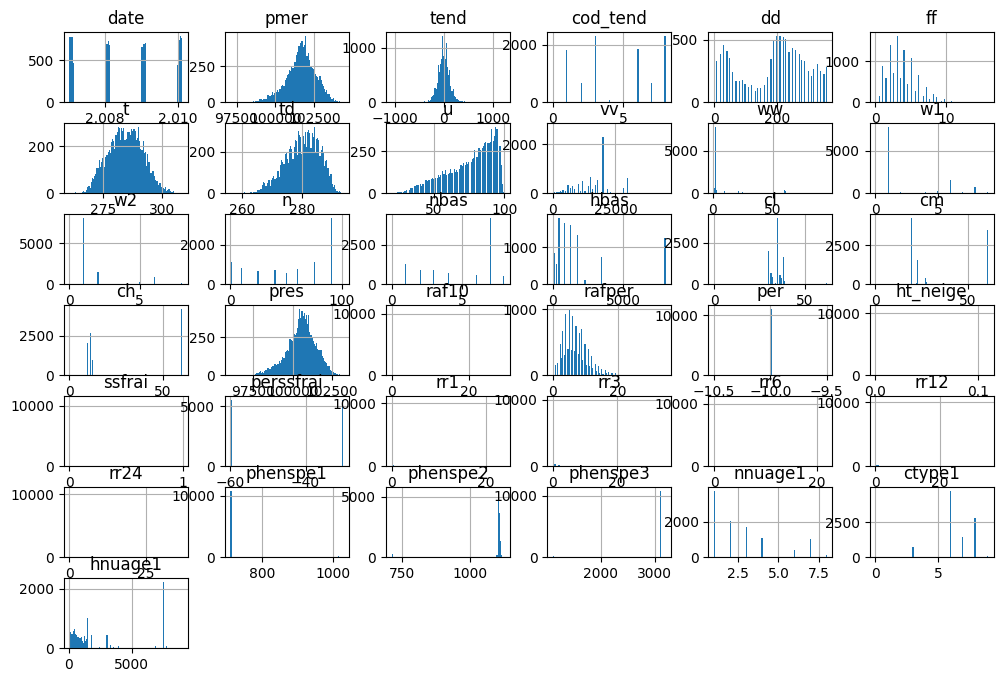

In [ ]:
#Suppression outliers par Z-score

#Pour étudier la distribution et choisir les bonnes features (distribution quasi normale)
df_weather_naive_dropna.hist(bins=100, figsize=(12, 8))

df_weather_outliers=outliers(df_weather_naive_dropna,['hbas','nbas','n','dd','ff', 'rr3', 'phenspe1', 'w2','u'])


## Prétraitement Conso


In [ ]:
#Convertir ce qui est possible en float, le reste devient NaN
columns_to_convert = ['global_active_power', 'global_reactive_power', 'voltage', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3']
for column in columns_to_convert:
    df_conso[column] = pd.to_numeric(df_conso[column], errors='coerce')

In [ ]:
#Suppression des données manquantes
df_conso_dropna=drop(df_conso).copy()

Nombre de lignes supprimées :  25975
Lignes restantes :  2027288
Pourcentage supprimé :  1.2650595661637112


In [ ]:
#Ajout consommation énergie par minute
df_conso_dropna['active_energy_consumed'] = (df_conso_dropna['global_active_power'] * 1000 / 60) - df_conso_dropna['sub_metering_1'] - df_conso_dropna['sub_metering_2'] - df_conso_dropna['sub_metering_3']

Nombre de ligne initialement 2027288
Nombre de lignes supprimées 102854
Pourcentage supprimé 5.073477473353564


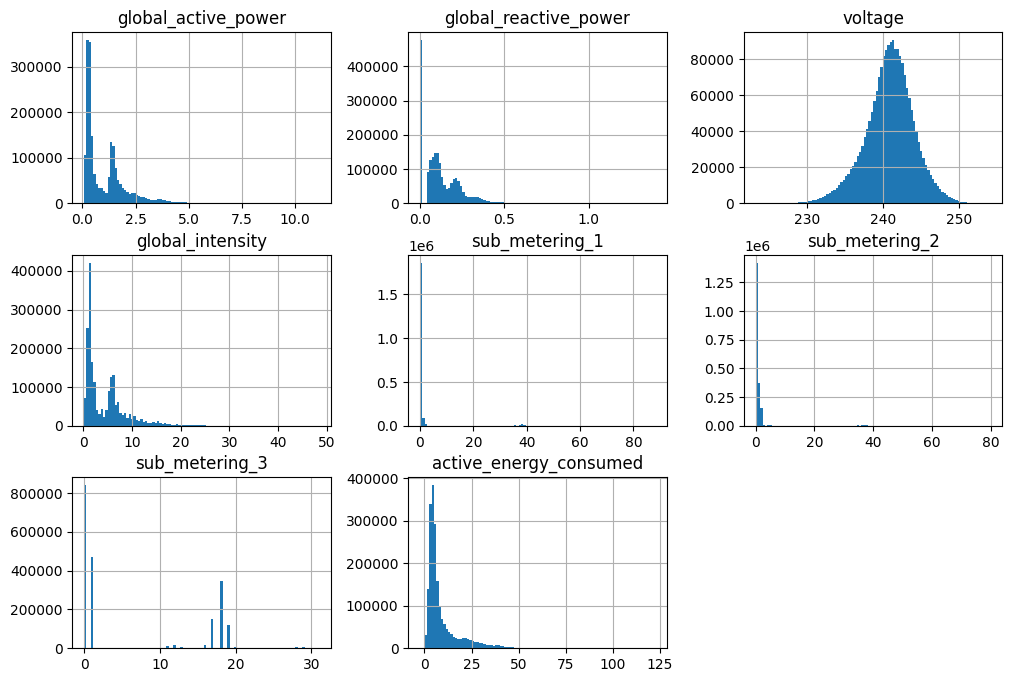

In [ ]:
#Suppression outliers par Z-score => Elimination des erreurs de capteurs

#Pour étudier la distribution et choisir les bonnes features (distribution quasi normale)
df_conso_dropna.hist(bins=100, figsize=(12, 8))

df_conso_outliers=outliers(df_conso_dropna,['voltage','global_active_power','global_reactive_power','global_intensity', 'global_active_power','active_energy_consumed'])



## Fusion


In [ ]:
#Fusion des deux datasets
#ATTENTION S'EXECUTE EN 3MIN
df1=df_conso_outliers.copy()
df2=df_weather_outliers.copy()

df1['datetime'] = pd.to_datetime(df1['date'] + ' ' + df1['time'], format='mixed')
df1.set_index('datetime', inplace=True)
df1.drop(['date', 'time'], axis=1, inplace=True)

df2['datetime'] = pd.to_datetime(df2['date'], format='%Y%m%d%H%M%S')
df2.set_index('datetime', inplace=True)
df2.drop('date', axis=1, inplace=True)

In [ ]:
#Dataset par heure
df1_hourly = df1.resample('3H').mean()
df2_hourly = df2.resample('3H').mean()

In [ ]:
# Fusion : Creation Hourly (3H) et Daily
df_hourly = pd.merge(df1_hourly, df2_hourly, left_index=True, right_index=True, how='outer')
df_daily = df_hourly.resample('D').mean()


In [ ]:
#Suppression des données manquantes
df_daily_final = drop(df_daily)
#df_hourly_final = drop(df_hourly)

Nombre de lignes supprimées :  50
Lignes restantes :  1411
Pourcentage supprimé :  3.4223134839151266


In [ ]:
#Elimination d'outliers avec le calcul du z-score => Elimination des anomalies de saisons de consommations d'énergies
df_daily_final2=outliers(df_daily_final,['active_energy_consumed'])


Nombre de ligne initialement 1411
Nombre de lignes supprimées 16
Pourcentage supprimé 1.1339475549255846


## Estimation Consommation selon Météo

In [ ]:
#Séparation Train / Test : X / Y
df_a=df_daily_final2.copy()
other='sub_metering_1'
target='active_energy_consumed'
columns_to_drop=[other,'voltage','global_active_power','global_reactive_power','global_intensity', 'sub_metering_2', 'sub_metering_3', 'global_active_power']
df=df_a.drop(columns_to_drop, axis=1).copy()

dataset_2010 = df[df.index.year == 2010]
dataset_other = df[df.index.year != 2010]

x_train=dataset_other.drop(target, axis=1)
y_train=dataset_other[target]
x_test=dataset_2010.drop(target, axis=1)
y_test=dataset_2010[target]


In [ ]:
#Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#ElasticNet
model = ElasticNet()

param_grid = {
    'alpha': [0.17, 0.18, 0.19],
    'l1_ratio': [0.9, 1]
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Meilleurs paramètres trouvés :", best_params)

model = ElasticNet(**best_params)

Meilleurs paramètres trouvés : {'alpha': 0.18, 'l1_ratio': 1}


In [ ]:
#Random Forest
param_grid = {
    'n_estimators': [220, 240,260],
    'max_depth': [5,6,7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

model=grid_search.best_estimator_


Meilleurs paramètres: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 240}


In [ ]:
#Regression polynomiale : temps d'éxecution : 3min !!
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

# Définir les degrés de polynôme à tester
param_grid = {
    'poly__degree': [1, 2, 3]
}

# Utiliser GridSearchCV pour trouver le meilleur degré
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=2, n_jobs=2)
grid_search.fit(x_train, y_train)

# Meilleurs paramètres
best_degree = grid_search.best_params_['poly__degree']
print("Meilleur degré trouvé :", best_degree)

# Meilleur modèle
model = grid_search.best_estimator_


Meilleur degré trouvé : 1


In [ ]:
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Coefficient of Determination (R²):", r2)

print("\nPrévisions vs Valeurs Réelles :")
df_predictions = pd.DataFrame({"Réel": y_test, "Prévisions": y_pred}, index=y_test.index)
print(df_predictions)

Mean Squared Error (MSE): 5.793525094875558
Mean Absolute Error (MAE): 1.8773659383011847
Coefficient of Determination (R²): 0.00381326020397621

Prévisions vs Valeurs Réelles :
                 Réel  Prévisions
datetime                         
2010-01-01   9.768504   10.479836
2010-01-02   8.144586   10.316045
2010-01-03   8.406861   10.630489
2010-01-04   7.767946   11.159452
2010-01-05   5.639357   11.119481
...               ...         ...
2010-12-07   6.739674   10.631221
2010-12-08   3.008542    9.985901
2010-12-09   9.480371    8.901923
2010-12-10   9.786261    9.432633
2010-12-11  10.571448    9.175643

[320 rows x 2 columns]


In [ ]:
#Métrique personnelle d'analyse
tot_pred=y_pred.mean()
tot_reel=y_test.mean()
df=df_daily_final.copy()
pourcentage_erreur = round(abs(tot_pred - tot_reel) / tot_reel * 100, 3)
print(f"Consommation réelle en 2007 : {df[df.index.year == 2007][target].mean()} Wh/min")
print(f"Consommation réelle en 2008 : {df[df.index.year == 2008][target].mean()} Wh/min")
print(f"Consommation réelle en 2009 : {df[df.index.year == 2009][target].mean()} Wh/min")
print(f"Consommation réelle en 2010 : {tot_reel} Wh/min")
print(f"Consommation prédite en 2010 : {tot_pred} Wh/min")
print(f"Pourcentage d'erreur sur la prédiction 2010 : {pourcentage_erreur}%")


Consommation réelle en 2007 : 8.66238743621834 Wh/min
Consommation réelle en 2008 : 8.610521105549404 Wh/min
Consommation réelle en 2009 : 8.3167145427721 Wh/min
Consommation réelle en 2010 : 7.985240557821451 Wh/min
Consommation prédite en 2010 : 8.366635278449934 Wh/min
Pourcentage d'erreur sur la prédiction 2010 : 4.776%


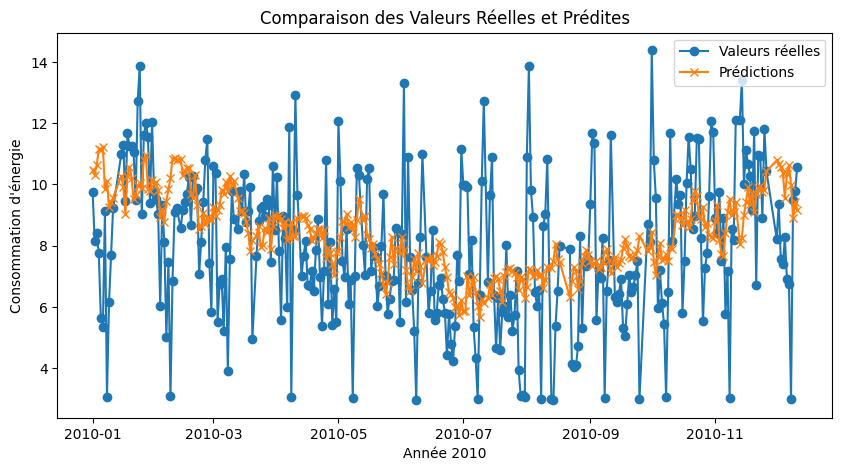

In [ ]:
#Affichage Valeurs réelles et prédictions de la consommation d'énergie
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Valeurs réelles', marker='o')
plt.plot(y_test.index, y_pred, label='Prédictions', marker='x')
plt.xlabel('Année 2010')
plt.ylabel('Consommation d\'énergie')
plt.title('Comparaison des Valeurs Réelles et Prédites')
plt.legend()
plt.show()

## Scaling Conso

In [ ]:
df=df_conso_outliers.copy()

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')


df['timestamp'] = pd.to_datetime(df['date'].dt.date.astype(str) + ' ' + df['time'])

#Etude par heure
df_conso_hourly = df.select_dtypes(include=[np.number]).groupby(df['timestamp'].dt.floor('H')).mean().reset_index()

#Etude journalière
df_conso_daily = df.select_dtypes(include=[np.number]).groupby(df['timestamp'].dt.date).mean().reset_index()

In [ ]:
#Comparaison perte de lignes
nb_day=24*60
nb_min=60
lg_min_final=len(df_conso_outliers)
print("Nombre de lignes après outliers : ", lg_min_final)
print("Conversion en day théorique : ", lg_min_final/nb_day)
print("Conversion en day pratique : ", len(df_conso_daily))
print("Conversion en heure théorique : ", lg_min_final/nb_min)
print("Conversion en heure pratique : ", len(df_conso_hourly))

print("Perte total pré-traitement pour daily:", (len(df_conso)/nb_day-len(df_conso_daily))/len(df_conso_daily)*100)
print("Perte total pré-traitement pour hour:", (len(df_conso)/nb_min-len(df_conso_hourly))/len(df_conso_hourly)*100)

Nombre de lignes après outliers :  1924434
Conversion en day théorique :  1336.4125
Conversion en day pratique :  1417
Conversion en heure théorique :  32073.9
Conversion en heure pratique :  33663
Perte total pré-traitement pour daily: 0.6264702422959283
Perte total pré-traitement pour hour: 1.6577548049787685


In [ ]:
#Drop de la date (pour faire fonctionner le scaler)
df_conso_daily_date=df_conso_daily.drop(columns=['timestamp']).copy()

In [ ]:
features = df_conso_daily_date

scaler_std = StandardScaler()
scaler_min_max = MinMaxScaler()

conso_daily_scaled = scaler_std.fit_transform(features)

df_conso_daily_scaled = pd.DataFrame(conso_daily_scaled, columns=df_conso_daily_date.columns)


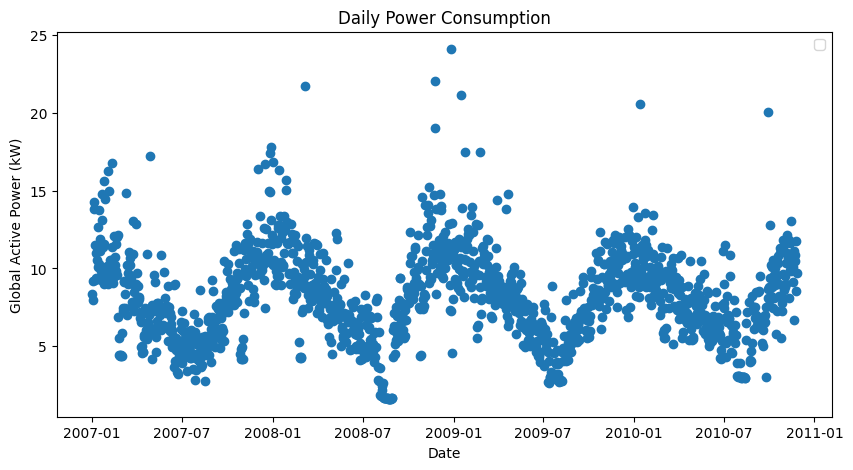

In [ ]:
df=df_conso_daily
plt.figure(figsize=(10,5))
plt.scatter(df['timestamp'], df['active_energy_consumed'])

plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('Daily Power Consumption')
plt.legend()
plt.show()



## Affichage Donnée Conso

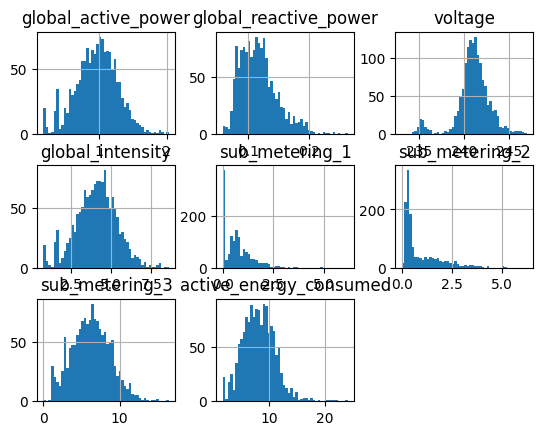

In [ ]:
df_conso_daily.hist(bins=50)
plt.show()


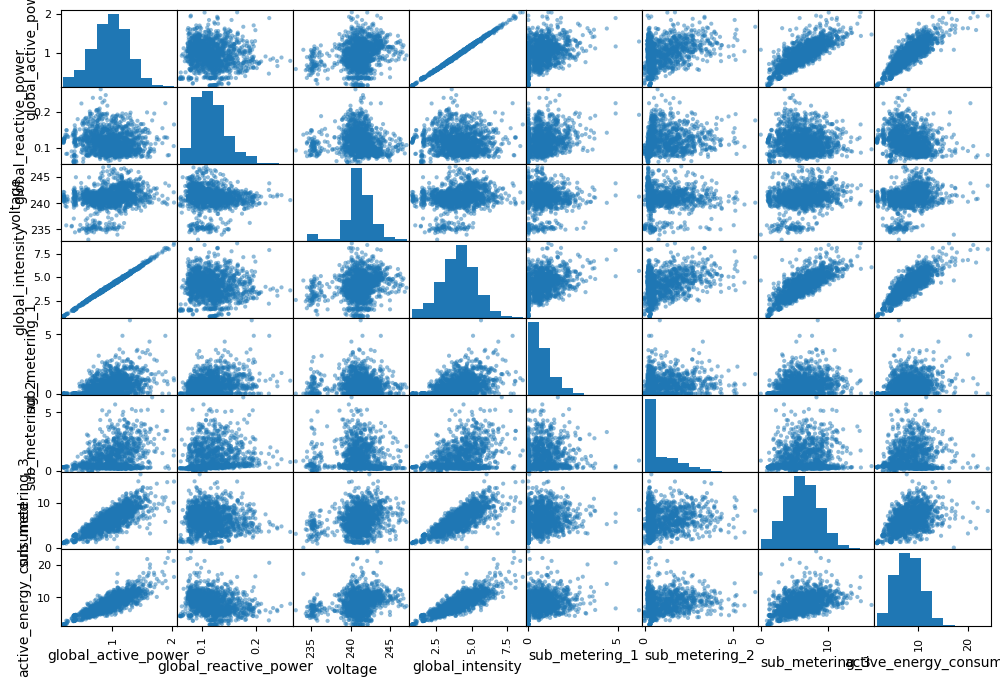

In [ ]:
scatter_matrix(df_conso_daily, figsize=(12, 8))
plt.show()

## Détermination nombre de cluster

Le nombre optimal de clusters identifié numériquement par la méthode des différences est : 4


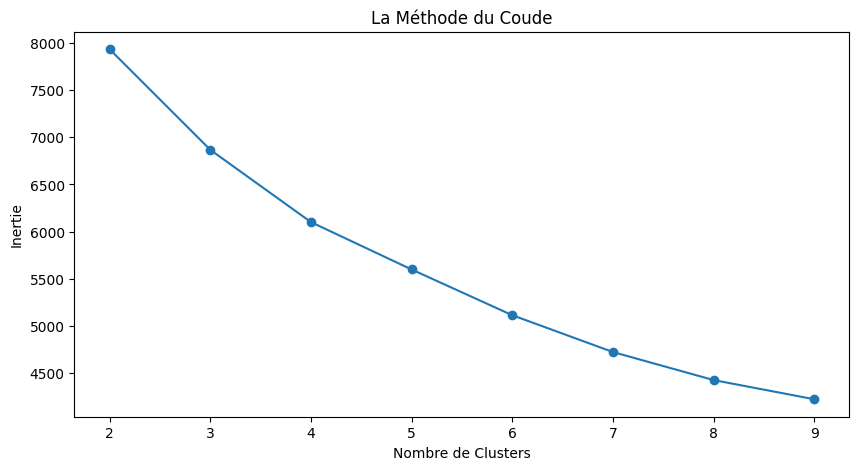

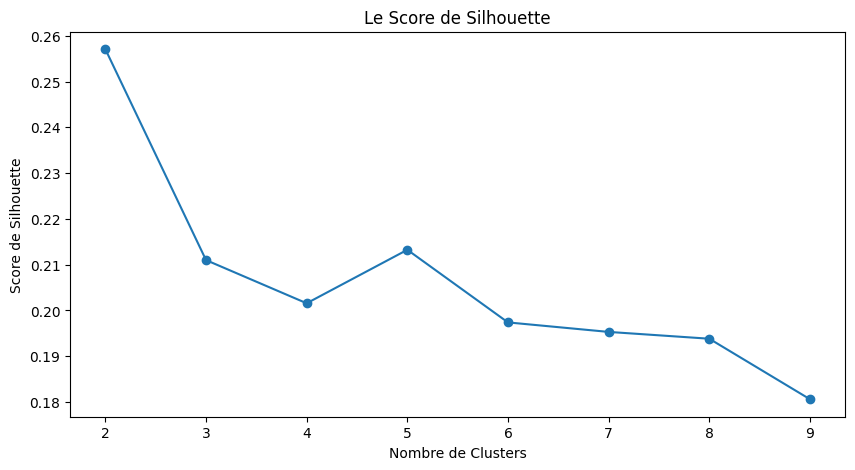

In [ ]:
inertia = []
silhouette_scores = []
features=df_conso_daily_scaled

K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20).fit(features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features, kmeans.labels_))


diff_inertia = np.diff(inertia)

diff_inertia_seconde = np.diff(diff_inertia)

k_optimal = np.argmin(diff_inertia_seconde) + 2  # +2 pour compenser le décalage

print(f"Le nombre optimal de clusters identifié numériquement par la méthode des différences est : {k_optimal}")

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, '-o')
plt.title("La Méthode du Coude")
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, '-o')
plt.title("Le Score de Silhouette")
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.show()


## Kmeans Conso

In [ ]:
k=2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=20).fit(df_conso_daily_scaled)



## Kmeans affichage

In [ ]:
df_affichage = pd.DataFrame({
    'date': df_conso_daily['timestamp'],
    'cluster': kmeans.labels_,
    'active_energy_consumed': df_conso_daily['active_energy_consumed']
})

df_affichage['date'] = pd.to_datetime(df_affichage['date']).dt.date
df_affichage.sort_values('date', inplace=True)

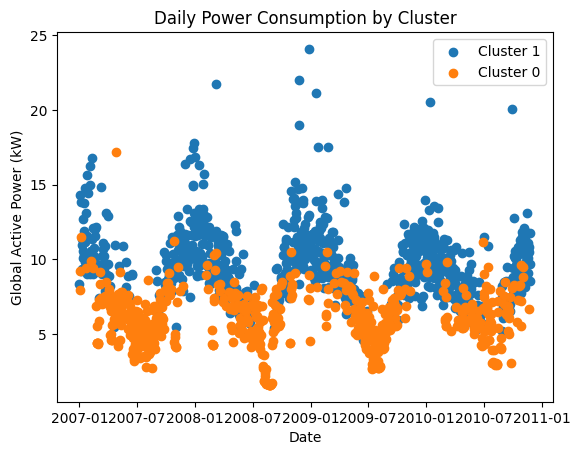

In [ ]:
df=df_affichage
#plt.figure(figsize=(12, 6))
for cluster_id in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_id]

    plt.scatter(cluster_data['date'], cluster_data['active_energy_consumed'], label=f'Cluster {cluster_id}')

plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('Daily Power Consumption by Cluster')
plt.legend()
plt.show()


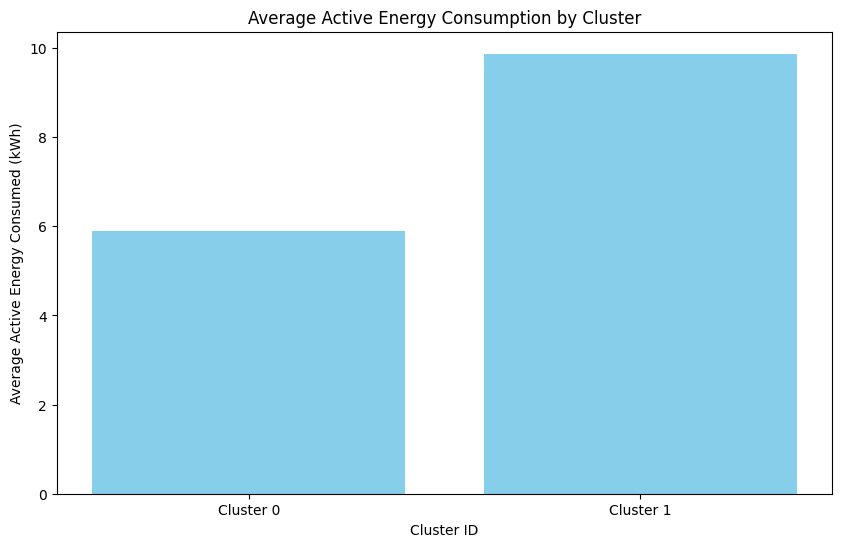

In [ ]:
cluster_means = df_affichage.groupby('cluster')['active_energy_consumed'].mean()

plt.figure(figsize=(10, 6))
plt.bar(cluster_means.index, cluster_means.values, color='skyblue')

plt.xlabel('Cluster ID')
plt.ylabel('Average Active Energy Consumed (kWh)')
plt.title('Average Active Energy Consumption by Cluster')
plt.xticks(cluster_means.index, [f'Cluster {i}' for i in cluster_means.index])

plt.show()


## Répartition par heure / par cluster Conso / Test de Kolmogorov-Smirnov

               date      time  global_active_power  global_reactive_power  \
0          1/1/2007  00:00:00                2.580                  0.136   
1          1/1/2007  00:01:00                2.552                  0.100   
2          1/1/2007  00:02:00                2.550                  0.100   
3          1/1/2007  00:03:00                2.550                  0.100   
4          1/1/2007  00:04:00                2.554                  0.100   
...             ...       ...                  ...                    ...   
2052055  26/11/2010  00:55:00                0.218                  0.060   
2052056  26/11/2010  00:56:00                0.218                  0.058   
2052057  26/11/2010  00:57:00                0.220                  0.058   
2052058  26/11/2010  00:58:00                0.218                  0.058   
2052059  26/11/2010  00:59:00                0.216                  0.060   

         voltage  global_intensity  sub_metering_1  sub_metering_2  \
0    

KeyError: 'active_energy_consumed'

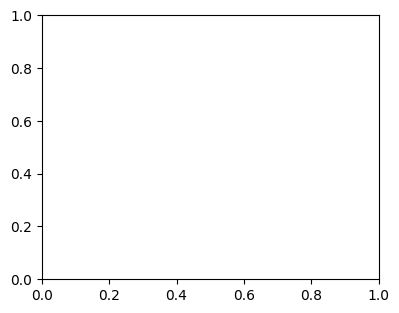

In [ ]:
df_conso['hour'] = pd.to_datetime(df_conso['time'], format='%H:%M:%S').dt.hour

plt.figure(figsize=(20, 24))

for hour in range(24):

    data = df_conso[df_conso['hour'] == hour]

    ax = plt.subplot(6, 4, hour + 1)
    print(data)

    ax.hist(data['active_energy_consumed'], bins=20, alpha=0.75, edgecolor='black')

    ax.set_title(f'Hour: {hour}')
    ax.set_xlabel('Active Energy Consumed')
    ax.set_ylabel('Occurrences')
    ax.grid(True)

In [ ]:
# Extraction de la date à partir du timestamp pour la jointure
df_conso_hourly['date'] = df_conso_hourly['timestamp'].dt.date

# Jointure des DataFrames sur la colonne 'date'
# Notez que df_affichage a déjà une colonne 'date', donc pas besoin d'extraire la date de 'timestamp' pour df_affichage
new_df = pd.merge(df_conso_hourly, df_affichage[['date', 'cluster']], on='date', how='left')

final_df = new_df[['timestamp', 'active_energy_consumed', 'cluster']]

final_df.dropna()

,timestamp,active_energy_consumed,cluster
0,2007-01-01 10:00:00,36.744444,1
1,2007-01-01 13:00:00,4.139394,1
2,2007-01-01 14:00:00,11.646328,1
3,2007-01-01 15:00:00,13.986111,1
4,2007-01-01 16:00:00,5.618333,1
...,...,...,...
33658,2010-11-26 17:00:00,15.898333,1
33659,2010-11-26 18:00:00,26.224444,1
33660,2010-11-26 19:00:00,26.510119,1
33661,2010-11-26 20:00:00,18.328333,1


In [ ]:
final_df['hour'] = pd.to_datetime(final_df['timestamp']).dt.hour

clusters = final_df['cluster'].unique()

n_cols = 4
n_rows = 6

for cluster in sorted(clusters):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 24))
    fig.suptitle(f'Cluster {cluster}', fontsize=16)

    for hour in range(24):
        data = final_df[(final_df['cluster'] == cluster) & (final_df['hour'] == hour)]
        data_points = data
        min = data['active_energy_consumed'].min()
        max = data['active_energy_consumed'].max()
        mean = data['active_energy_consumed'].mean()


        n, bins, patches = ax.hist((data['active_energy_consumed']), bins=20, alpha=0.75, edgecolor='black')
        bin_widths = np.diff(bins)


        n_normalized = (n) / (bin_widths * n.sum())

        ax2 = axes[hour // n_cols, hour % n_cols ]
        ax2.hist(bins[:-1], bins=bins, weights=n_normalized, alpha=0.75, edgecolor='black')

        ax2.set_title('Histogramme Normalisé')
        ax2.set_xlabel('Active Energy Consumed')
        ax2.set_ylabel('Densité de Probabilité')


        bin_centers = (bins[:-1] + bins[1:]) / 2
        weighted_mean = np.sum(bin_centers * n_normalized) / np.sum(n_normalized)
        std = np.sqrt(np.sum((bin_centers - mean)**2) / np.sum(n))

        x = np.linspace(mean - 4*std, mean + 4*std, 100)
        y = norm.pdf(x, mean, std)

        data_points = []
        for i in range(len(n_normalized)):
            data_points.extend(np.linspace(bins[i], bins[i+1], int(np.floor(n_normalized[i]*40+1)), endpoint=False))

        data_points = np.array(data_points)
        mean = np.mean(data_points)
        std = np.std(data_points)

        ks_statistic, p_value = kstest(data_points, 'norm', args=(mean, std))
        ax2.set_title(np.round(p_value, 4))


        ax2.plot(x, y, 'r-', label='Distribution Normale')

    plt.tight_layout()



NameError: name 'pd' is not defined

## Affichage Supp

In [ ]:
hourly_energy_sum = df_conso.groupby(df_conso['timestamp'].dt.hour)['active_energy_consumed'].mean().reset_index()

hourly_energy_sum.plot(kind='bar', x='timestamp', y='active_energy_consumed')
plt.xlabel('Hour of Day')
plt.ylabel('Total Active Energy Consumed')
plt.title('Total Active Energy Consumption by Hour of Day')
plt.show()


KeyError: 'timestamp'

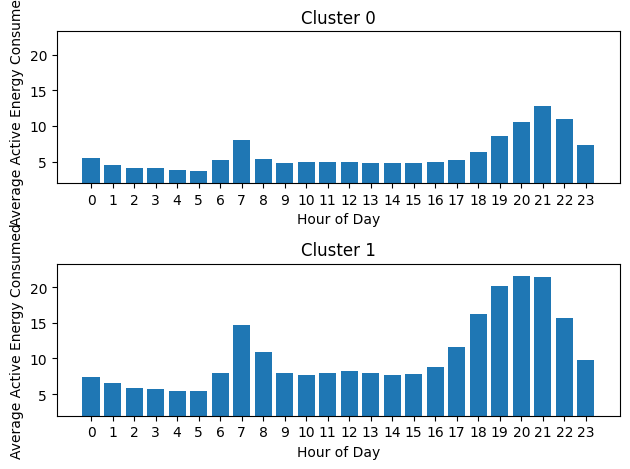

In [ ]:
# Regroupement par cluster et heure, puis calcul de la moyenne de la consommation d'énergie
hourly_energy_by_cluster = final_df.groupby(['cluster', final_df['timestamp'].dt.hour])['active_energy_consumed'].mean().reset_index(name='mean_energy_consumed')

num_clusters = hourly_energy_by_cluster['cluster'].unique().shape[0]

global_min = hourly_energy_by_cluster['mean_energy_consumed'].min()
global_max = hourly_energy_by_cluster['mean_energy_consumed'].max()

# Un petit ajustement pour mieux visualiser les graphiques
margin = (global_max - global_min) * 0.1
global_min -= margin
global_max += margin

#plt.figure(figsize=(10, 4 * num_clusters))

for i, cluster in enumerate(hourly_energy_by_cluster['cluster'].unique(), start=1):
    plt.subplot(num_clusters, 1, i)

    cluster_data = hourly_energy_by_cluster[hourly_energy_by_cluster['cluster'] == cluster]

    plt.bar(cluster_data['timestamp'], cluster_data['mean_energy_consumed'])

    plt.ylim(global_min, global_max)

    plt.title(f'Cluster {cluster}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Active Energy Consumed')
    plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()


